In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/Pothole-dataset/PotholeDataset.zip'  #Change the zip file name as needed

Archive:  /content/drive/MyDrive/Pothole-dataset/PotholeDataset.zip
   creating: PotholeDataset/test/
   creating: PotholeDataset/test/Plain/
  inflating: PotholeDataset/test/Plain/1.jpg  
  inflating: PotholeDataset/test/Plain/2.jpg  
  inflating: PotholeDataset/test/Plain/3.jpg  
  inflating: PotholeDataset/test/Plain/4.jpg  
  inflating: PotholeDataset/test/Plain/5.jpg  
  inflating: PotholeDataset/test/Plain/6.jpg  
  inflating: PotholeDataset/test/Plain/7.jpg  
  inflating: PotholeDataset/test/Plain/8.jpg  
   creating: PotholeDataset/test/Pothole/
  inflating: PotholeDataset/test/Pothole/531.jpg  
  inflating: PotholeDataset/test/Pothole/593.jpg  
  inflating: PotholeDataset/test/Pothole/598.jpg  
  inflating: PotholeDataset/test/Pothole/602.jpg  
  inflating: PotholeDataset/test/Pothole/605.jpg  
  inflating: PotholeDataset/test/Pothole/610.jpg  
  inflating: PotholeDataset/test/Pothole/617.jpg  
  inflating: PotholeDataset/test/Pothole/618.jpg  
   creating: PotholeDataset/trai

# **Importing all the required libraries**

In [3]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import InputLayer

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image
import keras.preprocessing.image as img
from keras.applications.resnet50 import ResNet50

# **Dataset is divided into two parts : test & train**
Both the directories (test and train) are divided further : Plain & Pothole

In [4]:
os.listdir('PotholeDataset/train')

['Pothole', 'Plain']

# Resizing the images into (256 * 256)

In [5]:
def make_train_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

        X.append(np.array(img))
        Z.append(str(label))

In [6]:
X=[]
Z=[]
IMG_SIZE=256
Plain='PotholeDataset/train/Plain'
Pothole='PotholeDataset/train/Pothole'

make_train_data('Plain',Plain)
make_train_data('Pothole',Pothole)

100%|██████████| 25/25 [00:00<00:00, 70.88it/s]


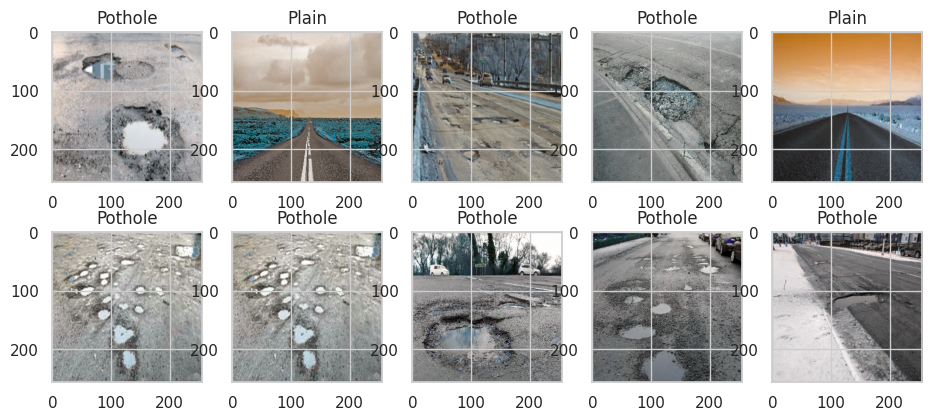

In [7]:
fig,ax=plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig.set_size_inches(10,10)

for i in range(2):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l][:])
        ax[i,j].set_title(Z[l])
        ax[i,j].set_aspect('equal')

# **Displaying the training data with labels**

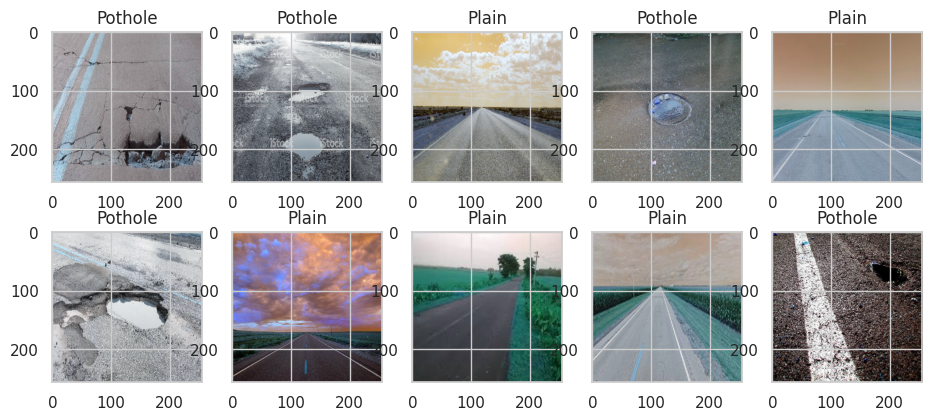

In [8]:
fig,ax=plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig.set_size_inches(10,10)

for i in range(2):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l][:])
        ax[i,j].set_title(Z[l])
        ax[i,j].set_aspect('equal')

# **Splitting the data into Training and Validation data**

In [9]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,2)
print(Y)
X=np.array(X)

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=1337)

np.random.seed(42)
rn.seed(42)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


# **Building the CNN model using RESNET (pretrained model)**

In [10]:
base_model=ResNet50(include_top=False, weights='imagenet',input_shape=(256,256,3), pooling='max')
base_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                      

In [11]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.20))
model.add(Dense(2048,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(2,activation='softmax'))


In [12]:
epochs=50
batch_size=128
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=2, verbose=1)
base_model.trainable=True # setting the VGG model to be trainable.
model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 30408066 (116.00 MB)
Trainable params: 303

In [13]:
History = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test,y_test))

Epoch 1/50
1/1 [==============================] - 63s 63s/step - loss: 1.0331 - accuracy: 0.7333 - val_loss: 95.2477 - val_accuracy: 0.6000
Epoch 2/50
1/1 [==============================] - 31s 31s/step - loss: 174.7148 - accuracy: 0.3000 - val_loss: 9.2107 - val_accuracy: 0.6000
Epoch 3/50
1/1 [==============================] - 37s 37s/step - loss: 3.7421 - accuracy: 0.3000 - val_loss: 254.6410 - val_accuracy: 0.4000
Epoch 4/50
1/1 [==============================] - 28s 28s/step - loss: 19.1584 - accuracy: 0.7000 - val_loss: 98.5284 - val_accuracy: 0.4000
Epoch 5/50
1/1 [==============================] - 32s 32s/step - loss: 1.7896 - accuracy: 0.7000 - val_loss: 78.1085 - val_accuracy: 0.6000
Epoch 6/50
1/1 [==============================] - 32s 32s/step - loss: 0.3709 - accuracy: 1.0000 - val_loss: 288.8704 - val_accuracy: 0.6000
Epoch 7/50
1/1 [==============================] - 34s 34s/step - loss: 0.4397 - accuracy: 0.9000 - val_loss: 695.6536 - val_accuracy: 0.6000
Epoch 8/50
1/1 

# **Saving the trained model**

In [24]:
model.save('pothole-detection/pothole-detection-model.h5')

# **Model Accuracy**

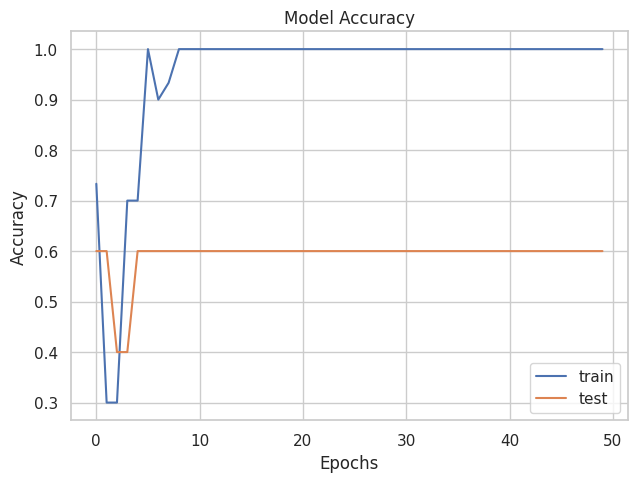

In [17]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

# **Model Loss**

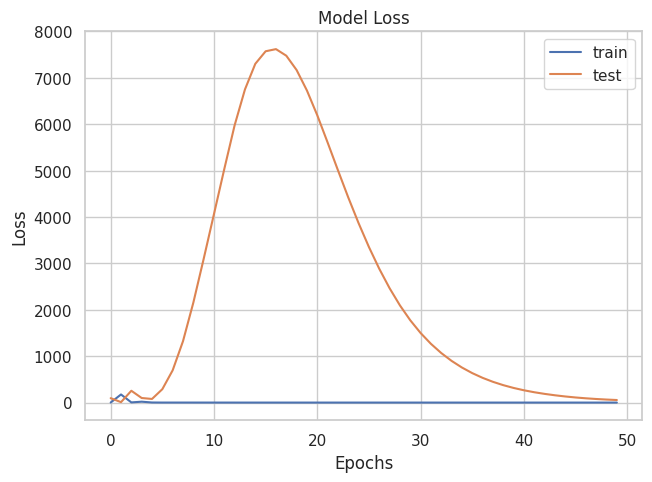

In [18]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

# **Testing the trained model**
[0,1] --> Pothole road

[1,0] --> Plain road

Testing the trained model on Pothole images

In [19]:
path = "PotholeDataset/test/Pothole"
files = os.listdir(path)
files

['598.jpg',
 '593.jpg',
 '617.jpg',
 '602.jpg',
 '610.jpg',
 '531.jpg',
 '618.jpg',
 '605.jpg']

  0%|          | 0/8 [00:00<?, ?it/s]

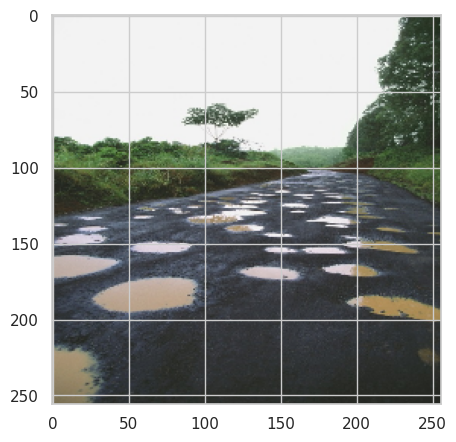

1/1 [==============================] - 1s 1s/step


 12%|█▎        | 1/8 [00:01<00:13,  1.92s/it]

Plain Road


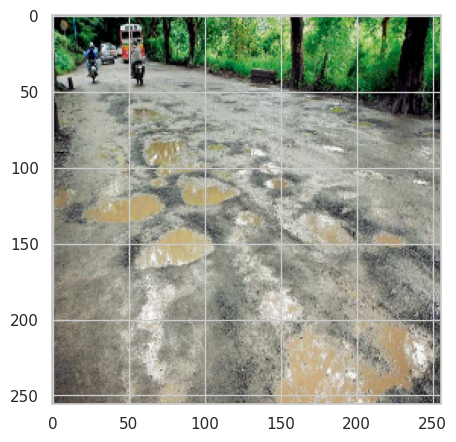

1/1 [==============================] - 0s 229ms/step


 25%|██▌       | 2/8 [00:02<00:07,  1.25s/it]

Plain Road


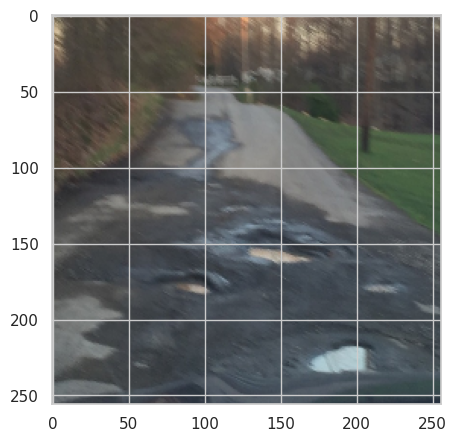

1/1 [==============================] - 0s 214ms/step


 38%|███▊      | 3/8 [00:03<00:05,  1.00s/it]

Plain Road


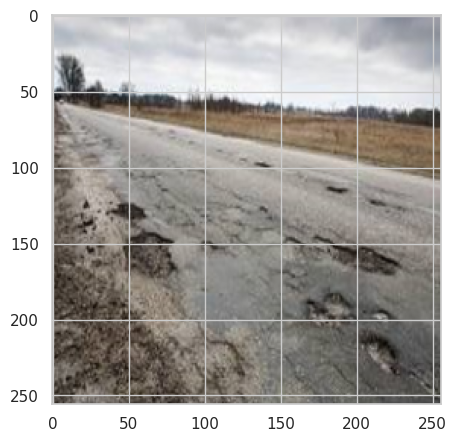

1/1 [==============================] - 0s 215ms/step


 50%|█████     | 4/8 [00:04<00:03,  1.15it/s]

Plain Road


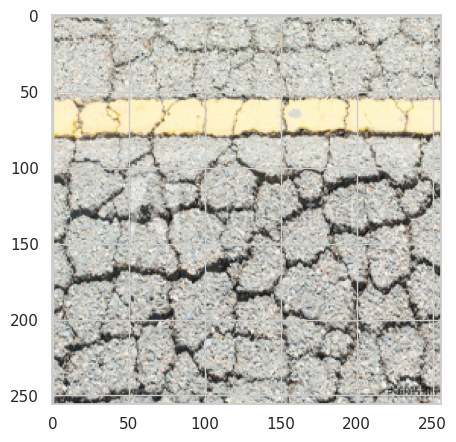

1/1 [==============================] - 0s 264ms/step


 62%|██████▎   | 5/8 [00:04<00:02,  1.19it/s]

Plain Road


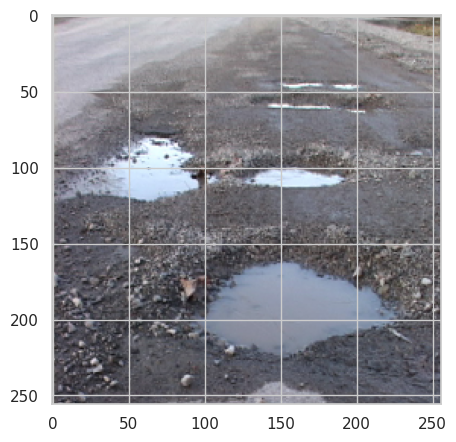

1/1 [==============================] - 0s 482ms/step


 75%|███████▌  | 6/8 [00:06<00:01,  1.06it/s]

Plain Road


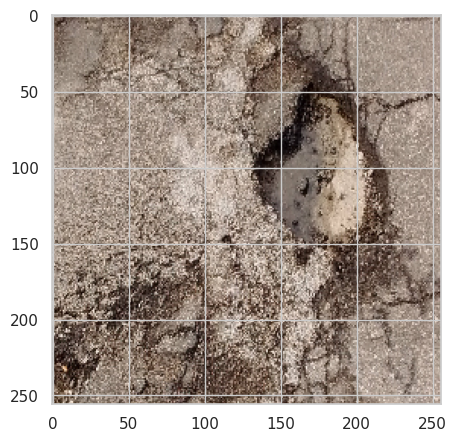

1/1 [==============================] - 0s 404ms/step


 88%|████████▊ | 7/8 [00:07<00:00,  1.01it/s]

Plain Road


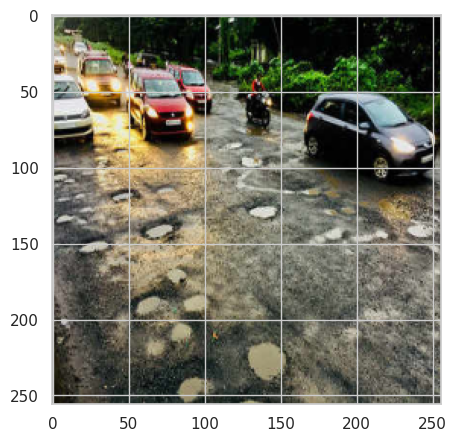

1/1 [==============================] - 0s 399ms/step


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]

Plain Road


In [20]:
for i in tqdm(files):
    pth = os.path.join(path,i)
    X = cv2.imread(pth,cv2.IMREAD_COLOR)
    X = cv2.resize(X,(256,256))
    plt.figure()
    plt.imshow(X[:,:,::-1])
    plt.show()

    X = np.array(X)
    X = np.expand_dims(X, axis=0)

    y_pred = np.round(model.predict(X))
    if y_pred[0][0] == 1:
        print("Plain Road")
    else:
        print("Pothole Road")

# **Testing the trained model on Plain images**

In [21]:
path = "PotholeDataset/test/Plain"
files = os.listdir(path)
files

['5.jpg', '6.jpg', '8.jpg', '1.jpg', '2.jpg', '4.jpg', '7.jpg', '3.jpg']

  0%|          | 0/8 [00:00<?, ?it/s]

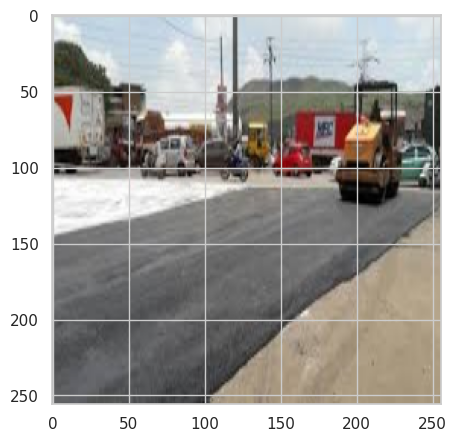

1/1 [==============================] - 0s 231ms/step


 12%|█▎        | 1/8 [00:00<00:04,  1.58it/s]

Plain Road


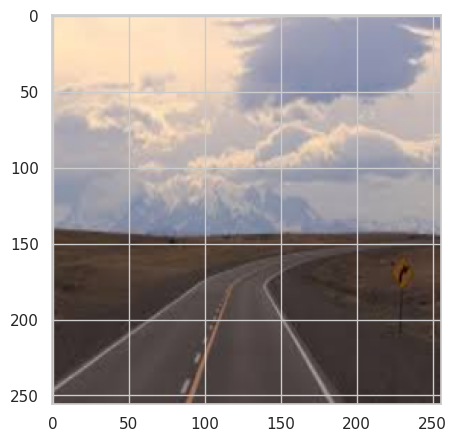

1/1 [==============================] - 0s 376ms/step


 25%|██▌       | 2/8 [00:01<00:04,  1.25it/s]

Plain Road


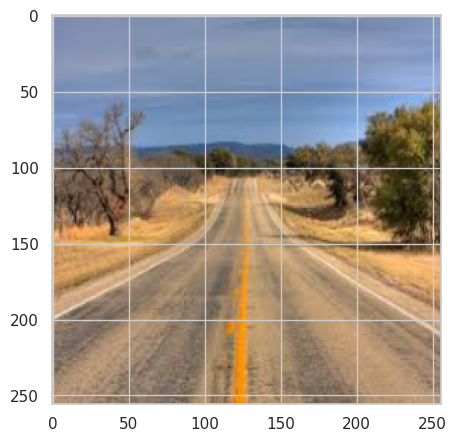

1/1 [==============================] - 0s 378ms/step


 38%|███▊      | 3/8 [00:02<00:05,  1.01s/it]

Plain Road


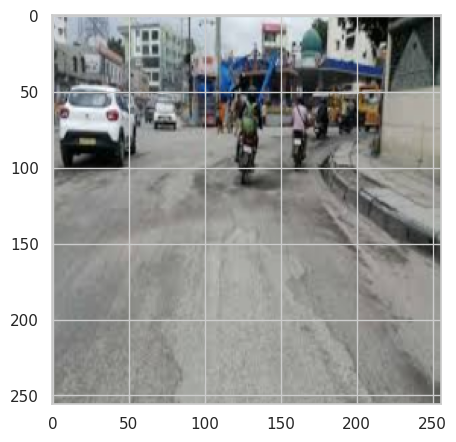

1/1 [==============================] - 0s 427ms/step


 50%|█████     | 4/8 [00:03<00:04,  1.03s/it]

Plain Road


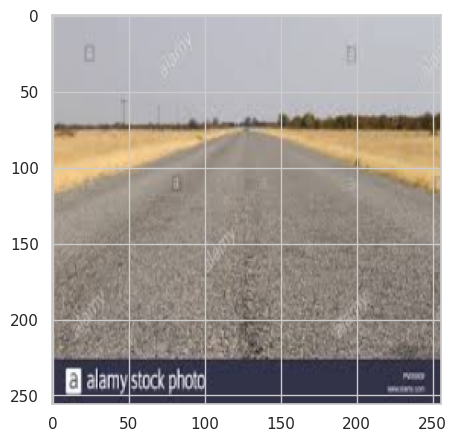

1/1 [==============================] - 0s 366ms/step


 62%|██████▎   | 5/8 [00:05<00:03,  1.11s/it]

Plain Road


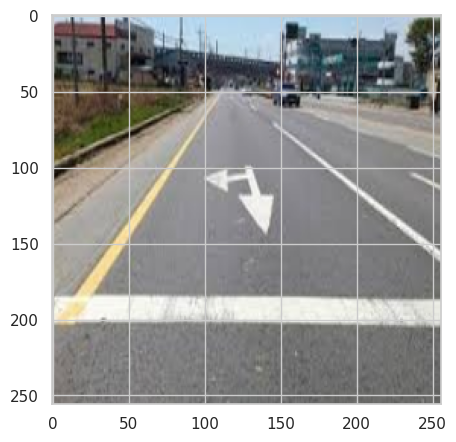

1/1 [==============================] - 0s 217ms/step


 75%|███████▌  | 6/8 [00:05<00:01,  1.05it/s]

Plain Road


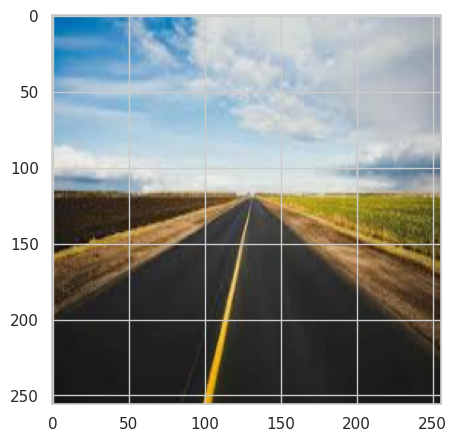

1/1 [==============================] - 0s 217ms/step


 88%|████████▊ | 7/8 [00:06<00:00,  1.15it/s]

Plain Road


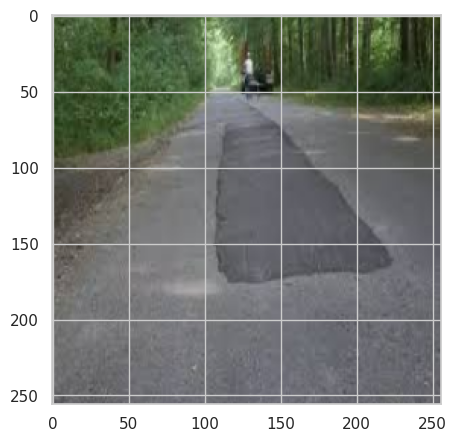

1/1 [==============================] - 0s 220ms/step


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]

Plain Road


In [22]:
for i in tqdm(files):
    pth = os.path.join(path,i)
    X = cv2.imread(pth,cv2.IMREAD_COLOR)
    X = cv2.resize(X,(256,256))
    plt.figure()
    plt.imshow(X[:,:,::-1])
    plt.show()


    X = np.array(X)
    X = np.expand_dims(X, axis=0)

    y_pred = np.round(model.predict(X))
    if y_pred[0][0] == 1:
        print("Plain Road")
    else:
        print("Pothole Road")